In [4]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', 'analysis'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', 'session'))

from imports import *
from loading import load_session_data
from correlation import cluster_corr

import numpy as np
import h5py, json
import matplotlib.pyplot as plt
from scipy import signal, stats
from target import build_tgt_matrix
from adapters import DatProcessor
from matplotlib.patches import ConnectionPatch
from mpl_toolkits.axes_grid1 import make_axes_locatable
from session.sessions import selected_009266, selected_008229, selected_009265, selected_57
from target import build_tgt_matrix, get_spike_counts, build_event_mx, \
        get_idxs_of_event_periods, get_spike_times_at
np.set_printoptions(suppress=True)

%matplotlib inline

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [41]:
#source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

sessions = selected_57
sessions.sort()
selected = [
    "57_SIT_2024-01-04_14-16-22",
    "57_SIT_2024-01-04_14-52-59",
]
selected

['57_SIT_2024-01-04_14-16-22', '57_SIT_2024-01-04_14-52-59']

## Experiment timeline plot

In [42]:
def to_normed(data):
    normed = data - data.min() 
    return normed/(normed.max() - normed.min())

In [43]:
session = selected[1]

animal = session.split('_')[0]

s_path     = os.path.join(source, animal, session)
meta_file  = os.path.join(source, animal, session, 'meta.h5')
desc_file  = os.path.join(source, animal, session, 'descendants.h5')
desc_file  = os.path.join(source, animal, session, 'descendants.h5')
units_file = os.path.join(source, animal, session, 'units.h5')
moseq_file = os.path.join(source, animal, session, 'analysis', 'MoSeq_tSNE_UMAP.h5')
moseq_units_glm = os.path.join(source, animal, session, 'analysis', 'MoSeq_units_GLM.h5')

with h5py.File(meta_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    tgt_mx = np.array(f['processed']['target_matrix'])
    events = np.array(f['processed']['sound_events'])
with h5py.File(moseq_file, 'r') as f:
    syl_ratio_mx  = np.array(f['syl_ratio_mx'])
    idxs_srm_tl   = np.array(f['idxs_srm_tl'])
with h5py.File(units_file, 'r') as f:
    unit_names = [x for x in f]
with h5py.File(desc_file, 'r') as f:
    speed = np.array(f['speed'])
    hd    = np.array(f['hd'])
    
# load units
unit_names, single_units, spike_times = [], {}, {}
with h5py.File(units_file, 'r') as f:
    unit_names = [x for x in f]
with h5py.File(units_file, 'r') as f:
    for unit_name in unit_names:
        spike_times[unit_name] = np.array(f[unit_name][H5NAMES.spike_times['name']])
        single_units[unit_name] = np.array(f[unit_name][H5NAMES.inst_rate['name']])

In [44]:
p_noi = events[events[:, 1] == -1]
p_sil = events[events[:, 1] == 0]
p_bgr = events[events[:, 1] == 1]
p_tgt = events[events[:, 1] == 2]

speed_ev = speed[events[:, 2].astype(np.int32)]
speed_ev.shape

(7199,)

In [40]:
# units
u_to_plot = ['2-17', '2-6' ]

print(stats.pearsonr(single_units[u_to_plot[0]], single_units[u_to_plot[1]]))

# speed corr
for unit in u_to_plot:
    print(stats.pearsonr(single_units[unit], speed))

(-0.585680981170126, 0.0)
(0.15886090379211923, 0.0)
(-0.08253284802478265, 1.6031378491492683e-269)


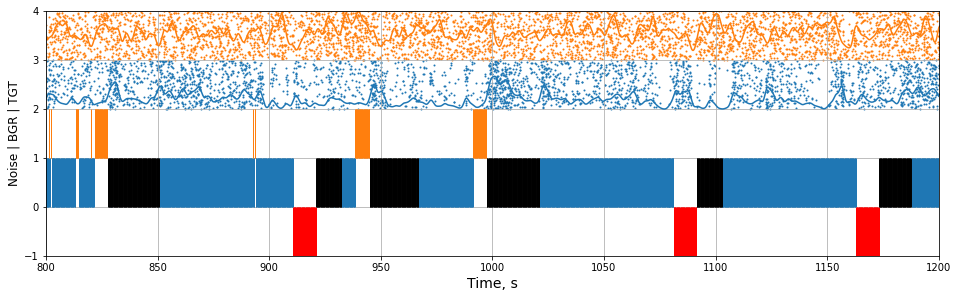

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4.5))

for i, unit in enumerate(u_to_plot):
    s_times = spike_times[unit]
    ax.scatter(s_times, 2 + i + np.random.rand(len(s_times)), s=1)
    ax.plot(tl[:, 0], 2 + i + to_normed(single_units[unit]))

# session events
ax.vlines(p_bgr, 0, 1, color='tab:blue', lw=1)
ax.vlines(p_tgt, 1, 2, color='tab:orange', lw=1)
ax.vlines(p_noi,-1, 0, color='red', lw=1)
ax.vlines(p_sil, 0, 1, color='black', lw=1, alpha=0.99)#, ls='--')
ax.set_xlim(800, 1200)
ax.set_ylim(-1, 4)
ax.set_xlabel("Time, s", fontsize=14)
ax.set_ylabel("Noise | BGR | TGT", fontsize=12)
ax.grid()

#fig.tight_layout()
#fig.savefig(os.path.join(report, 'Hall', 'session_timeline_full.png'), dpi=500)

## Correlation matrix

In [45]:
units_ccr = unit_names
s_rate = 100

l = len(units_ccr)
corr_pearson, corr_spearman = np.zeros((l, l)), np.zeros((l, l))
for i, u1 in enumerate(units_ccr):
    for j, u2 in enumerate(units_ccr):
        i_rate1 = single_units[u1]
        i_rate2 = single_units[u2]

        if u1 == '7-18' and session == '008229_hippoSIT_2022-05-16_20-36-44':
            i_rate1[1930*s_rate:1950*s_rate] = 0
        if u2 == '7-18' and session == '008229_hippoSIT_2022-05-16_20-36-44':
            i_rate2[1930*s_rate:1950*s_rate] = 0
            
        corr_pearson[i, j]  = stats.pearsonr(i_rate1, i_rate2)[0]
        #corr_spearman[i, j] = spearmanr(i_rate1, i_rate2)[0]

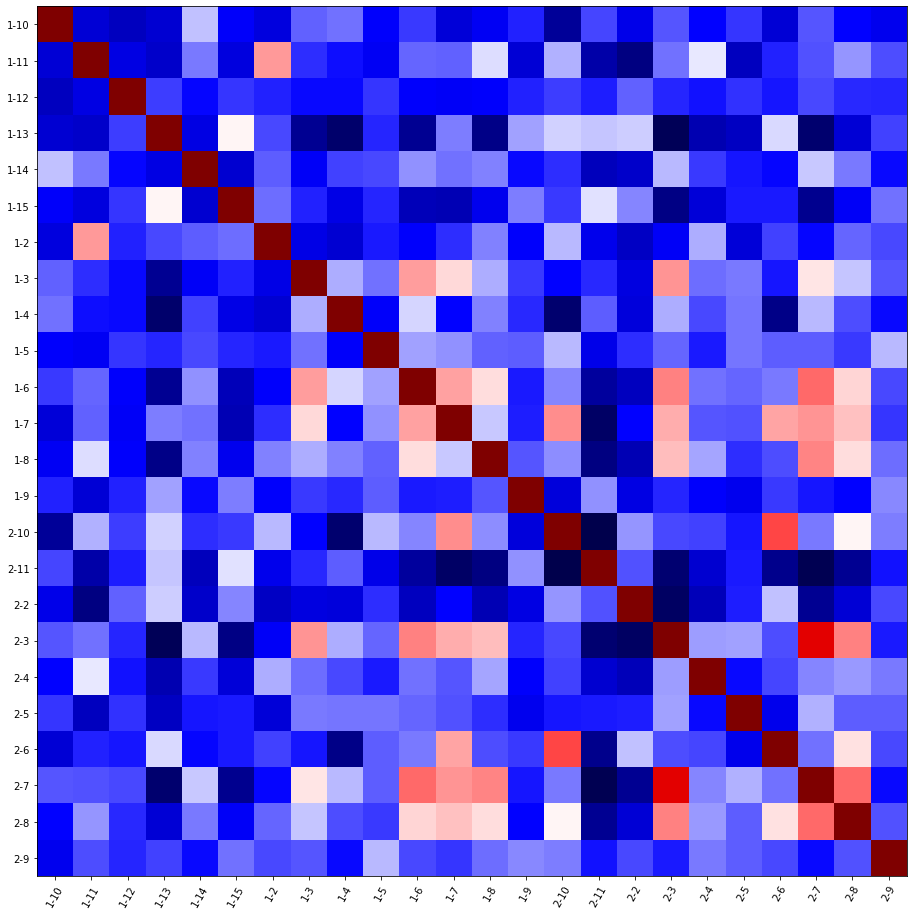

In [46]:
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111)
ax.imshow(corr_pearson, cmap='seismic')
ax.set_xticks(range(corr_pearson.shape[0]))
ax.set_xticklabels(units_ccr, rotation=60)
ax.set_yticks(range(corr_pearson.shape[0]))
_ = ax.set_yticklabels(units_ccr)

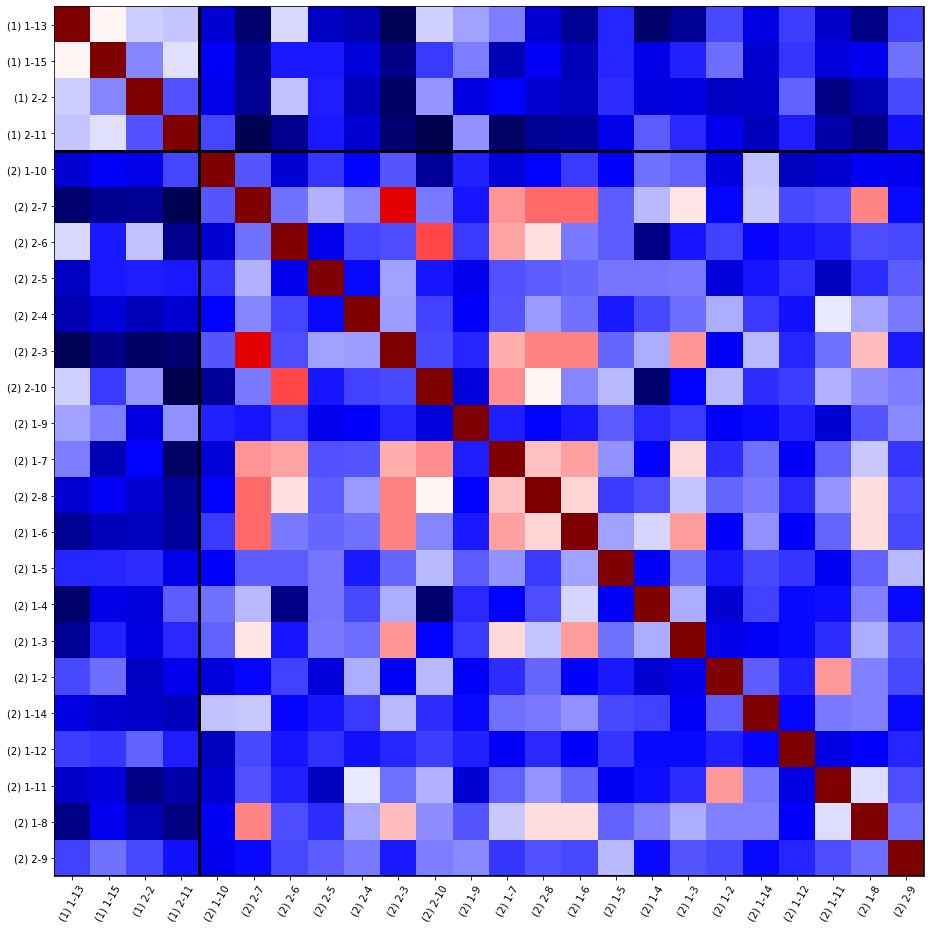

In [47]:
corr_srt, Z, labels, idxs_sort = cluster_corr(corr_pearson, threshold=2.6)

tick_labels = ["(%s) %s" % (labels[j], units_ccr[j]) for j in idxs_sort]

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111)
ax.imshow(corr_srt, cmap='seismic')
ax.set_xticks(range(corr_srt.shape[0]))
ax.set_xticklabels(tick_labels, rotation=60)
ax.set_yticks(range(corr_srt.shape[0]))
_ = ax.set_yticklabels(tick_labels)
for clu_no in set(labels):
    l_pos = np.where(labels[idxs_sort] == clu_no)[0][-1] + 0.5
    ax.axhline(l_pos, color='black', lw=3)
    ax.axvline(l_pos, color='black', lw=3)